Помимо классических алгоритмов векторизации, которые подсчитывают частоту встречаемости слов (мешок слов, TF-IDF), возможно использование векторных представлений, полученных с помощью языковой модели.

Для получения контекстуализированного векторного представления слова $t_k$ двунаправленная языковая модель ELMo использует конкатенацию векторов, полученных на основе обработки предшествующего контекста $t_1, ..., t_{k-1}$ и последующего контекста $t_{k+1}, \dots, t_N$.

Однако при анализе левого и правого контекста отдельно часть информации может теряться. Получить векторные представления слов, учитывая левый и правый контекст одновременно, позволяет языковая модель BERT.

## Языковая модель BERT

Появившись в 2018 году, модель BERT произвела настоящий прорыв, установив новые рекорды в большей части задач обработки текстов.

[Devlin J. et al. (2018) BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805).

Модель, которая  позволяет "закодировать" каждый токен и предложение целиком, называется энкодером. BERT состоит из нескольких блоков энкодеров, каждый из которых имеет одинаковую архитектуру и принимает на вход результат предыдущего блока.

Две конфигурации: базовая (base) – 12 слоев, расширенная (large) – 24 слоя.

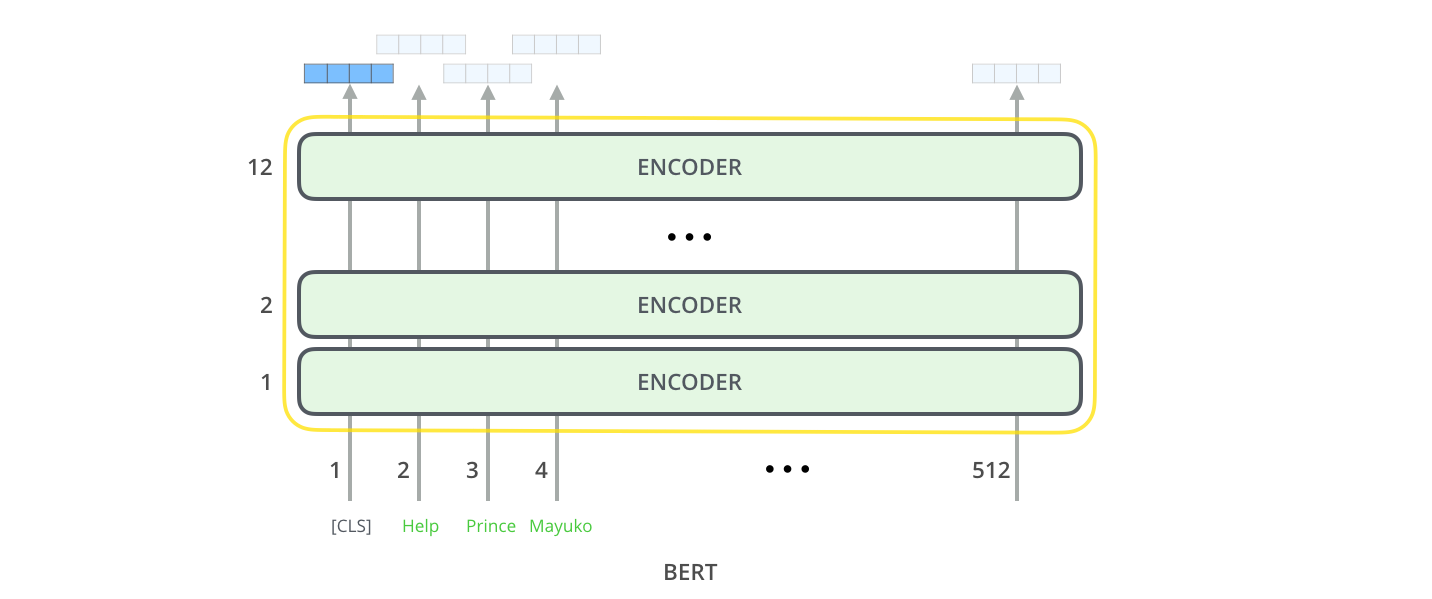

### Токенизация

Модель BERT использует метод токенизации WordPiece. Наиболее частые слова включаются в словарь целиком (слово = токен). Если слово является менее частотным и отсутствует в словаре, оно разбивается на части, которые включены в словарь (слово =  токен$_1$ + токен$_2$ + ...  + токен$_n$).

Векторное представление каждого токена содержит:
- представление самого токена
- номер его предложения
- позицию токена внутри предложения


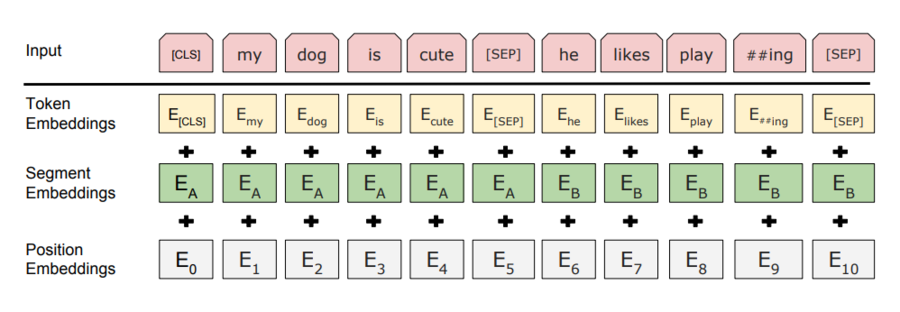

### Механизм внутреннего внимания

На вход модель получает последовательность токенов, на выходе отдает векторное представление для каждого токена, обогащенное контекстом. Входная последовательность, поступающая в энкодер, проходит через слой внутреннего внимания (self-attention). По мере того как модель обрабатывает каждое слово входной последовательности, внутреннее внимание позволяет "взглянуть" на другие слова и лучше закодировать данное слово.

Обученные модели можно скачать с помощью библиотеки [Transformers](https://huggingface.co/docs/transformers/index). Интерактивный инструмент [BertViz](https://github.com/jessevig/bertviz) позволяет визуализировать распределение внимания в языковых моделях.

In [ ]:
!pip install transformers bertviz -q

In [ ]:
from bertviz import head_view
from transformers import AutoTokenizer, AutoModel

model_version = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_version)
model = AutoModel.from_pretrained(model_version, output_attentions=True)

In [ ]:
inputs = tokenizer.encode("the dog loves to play in the park", return_tensors='pt')
outputs = model(inputs)
attention = outputs[-1]
tokens = tokenizer.convert_ids_to_tokens(inputs[0])
head_view(attention, tokens)

### Предобучение

Предобучение модели осуществляется на большом количестве неразмеченных текстовых данных.

BERT обучается одновременно на двух задачах:

- маскированное языковое моделирование (masked language modeling, MLM)

На вход BERT подаются токенизированные пары предложений, где некоторые токены скрыты — заменены на спецтокен `[MASK]`. Модель должна предсказать наиболее вероятный токен на месте маски. Обучение на задаче маскированного языкового моделирования позволяет получить контекстуализированные векторы токенов. Предобученные векторы слов можно использовать в других задачах обработки текста.

- предсказание следующего предложения (next sentence prediction, NSP)

Задача предсказания следующего предложения относится к бинарной классификации. Модель должна предсказать, является ли второе предложение продолжением первого. Предложения разделены спецтокеном `[SEP]`. За классификацию отвечает спецтокен `[CLS]`. Он содержит векторное представление обо всем предложении.

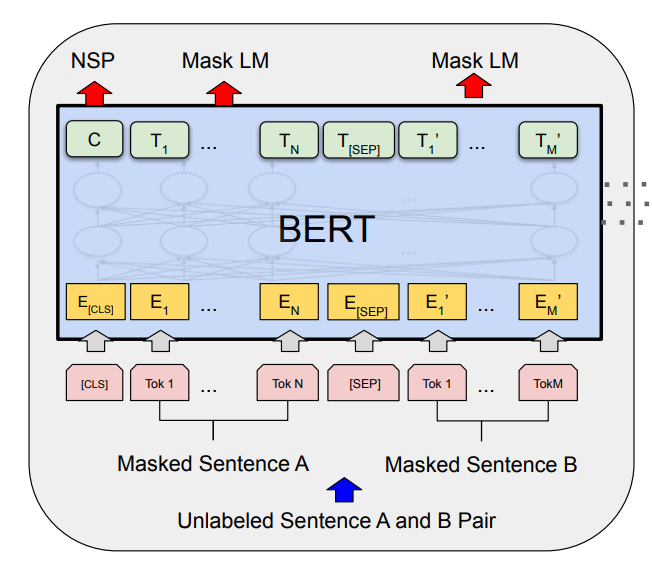

### Дообучение

Предобученные модели используются для подсчета векторных представлений слов и предложений и дообучения (fine-tuning) для целевой задачи. «Поверх» модели добавляет линейный слой. Математически может быть описан следующей формулой:

$y = activation(x * W  + b)$,

где $x$ — входные данные (вектор длины $d$),

$W$ — веса (матрица $d×k$, на которую умножается вектор),

$b$ — сдвиг (вектор длины $k$, который добавляется к выходным данным),

$activation$ — функция активации, которая применяется к выходным данным,

$y$ — выходные данные слоя (вектор длины $k$).


При классификации предложений на вход линейного слоя поступает векторное представление токена `[CLS]`. Его длина $d$ определяется свойствами модели. При умножении на матрицу весов $W$  $d$-мерный вектор преобразуется в $k$-мерный. Число $k$ определяется количеством классов для задачи ($k=2$ для бинарной классификации, $k>2$ для многоклассовой классификации).

Изначально матрица весов $W$ заполнена случайными числами. При дообучении происходит настройка весов, чтобы на целевой задаче ошибка была минимальной.

Для дообучения требуется существенно меньший объем размеченных данных (около 10000 предложений).

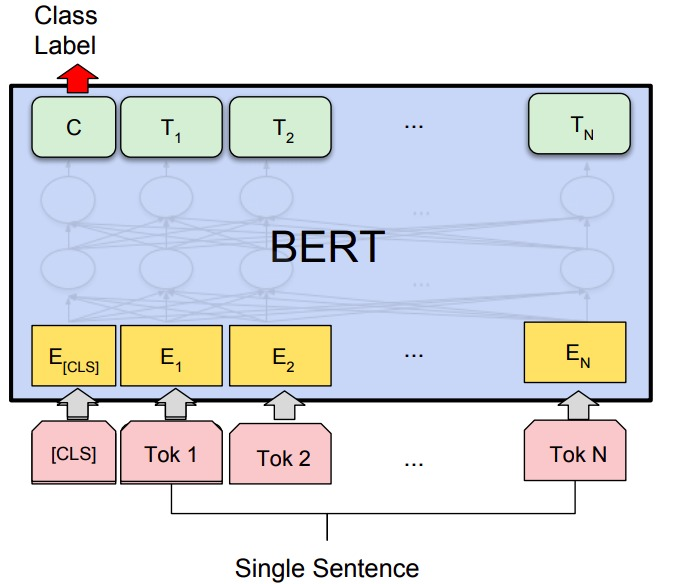

## Дистилляция знаний как метод ускорения нейронных сетей

Такие модели как BERT долго обучаются и много весят, но позволяют получить высокие оценки качества. На практике может не хватать времени и ресурсов для обучения и хранения большой модели. Однако обучение легкой модели не дает высоких показателей качества.

Легкая модель 👶🏼 — быстрая, но не точная

Продвинутая модель 👵🏻 — точная, но не быстрая

Существует способ для создания уменьшенной версии нейронных сетей – дистилляция знаний (knowledge distillation).

1. На большом объеме данных обучаем продвинутую модель 👵🏻. Можно взять заранее предобученную модель.

2. Обучаем маленькую легкую модель 👶🏼 воспроизводить предсказания большой модели 👵🏻. Используем задачу маскированного языкового моделирования. Ждем от маленькой модели 👶🏼 не предсказания правильного слова, а копирования поведения продвинутой модели 👵🏻.

Модель-ученик обучается воспроизводить предсказания модели-учителя, что достигается при использовании особой функции потерь:

$L_{student} = - \sum_i t_ilogs_i$, $t$ – предсказания учителя 👵🏻, $s$ – предсказания ученика 👶🏼.

`[CLS] The cat [MASK] on the mat`

Пусть наиболее вероятный токен на месте маски – `sat`. Но большая модель 👵🏻 знает, что в этом контексте также уместны токены `perched`, `seated`, `hopped`. Это знание полезно для обучения маленькой модели 👶🏼. Его можно передать, заставляя маленькую модель не только предсказывать высокую вероятность правильного токена `sat`, а воспроизводить всё вероятностное распределение возможных замаскированных токенов в данном тексте.

[ Sanh V. et al. (2020) DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter.](https://arxiv.org/abs/1910.01108)

DistilBERT весит на 40% меньше, чем оригинальная BERT-модель, она на 60% быстрее ее и сохраняет 97% ее функциональности. DistilBERT можно дообучить на целевую задачу и получить разумные оценки качества.

### ruBERT-tiny

Рассмотрим дистиллированный BERT для русского языка — ruBERT-tiny ([первая версия](https://huggingface.co/cointegrated/rubert-tiny), [обновленная версия](https://huggingface.co/cointegrated/rubert-tiny2)) или просто Энкодечка. Создатель этой модели — NLP-исследователь Давид Дале. Модель описана в статьях на Хабре.

[Дале Д. (2021) Маленький и быстрый BERT для русского языка.](https://habr.com/ru/articles/562064/)

[Дале Д. (2022) Рейтинг русскоязычных энкодеров предложений.](https://habr.com/ru/articles/669674/)

В качестве модели-ученика взят [мультиязычный BERT](https://huggingface.co/bert-base-multilingual-cased), чтобы модель понимала и русский, и английский. Словарь этой модели содержит 120 000 токенов, но были отобраны только 30 000, которые часто встречаются в русском и английском языках. Размер эмбеддинга сокращен с 768 до 312, число слоёв – с 12 до 3.

Маленький русскоязычный BERT был создан в первую очередь для классификации коротких текстов. Он должен уметь построить хорошее векторное представление предложения. В качестве учителей для дистилляции были выбраны модели, которые с этим хорошо справляются:
- RuBERT ([статья](https://arxiv.org/abs/1905.07213), [модель](https://huggingface.co/DeepPavlov/rubert-base-cased-sentence))

Мультиязычная модель BERT‑base была дообучена на русской части Википедии и новостных данных.

- LaBSE ([статья](https://arxiv.org/abs/2007.01852), [модель](https://huggingface.co/sentence-transformers/LaBSE))

Модель LaBSE (language-agnostic BERT sentence embeddings) обучалась на выборке текстов на 100+ языков. Основная задача – сближать друг с другом векторы предложений с одинаковым смыслом на разных языках.

- Laser ([статья](https://arxiv.org/abs/1812.10464), [пакет](https://pypi.org/project/laserembeddings/))

- USE ([статья](https://arxiv.org/abs/1803.11175), [код](https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3))

LASER (Language-Agnostic SEntence Representations) и USE (Universal Sentence Encoder) — это инструменты для вычисления векторов предложений.

Помимо предсказания замаскированных токенов, веткор токена `[CLS]` модели-ученика должен предсказывать векторы предложений, полученные из этих четырёх моделей. Дополнительно модель обучалась на задачу translation ranking (как LaBSE): вектор предложения на русском языке должен быть ближе к вектору его перевода на английский, чем к вектору остальных примеров в батче.

В качестве обучающей выборки взято три параллельных корпуса англо-русских предложений: от [Яндекс.Переводчика](https://translate.yandex.ru/corpus), [OPUS-100](https://huggingface.co/datasets/opus100) и [Tatoeba](https://huggingface.co/datasets/tatoeba), суммарно 2,5 млн коротких текстов.

RuBERT-tiny2 – это доработанная версия ruBERT-tiny: расширен словарь модели c 30 000 до 80 000 токенов, увеличена максимальная длина текста с 512 до 2048 токенов.

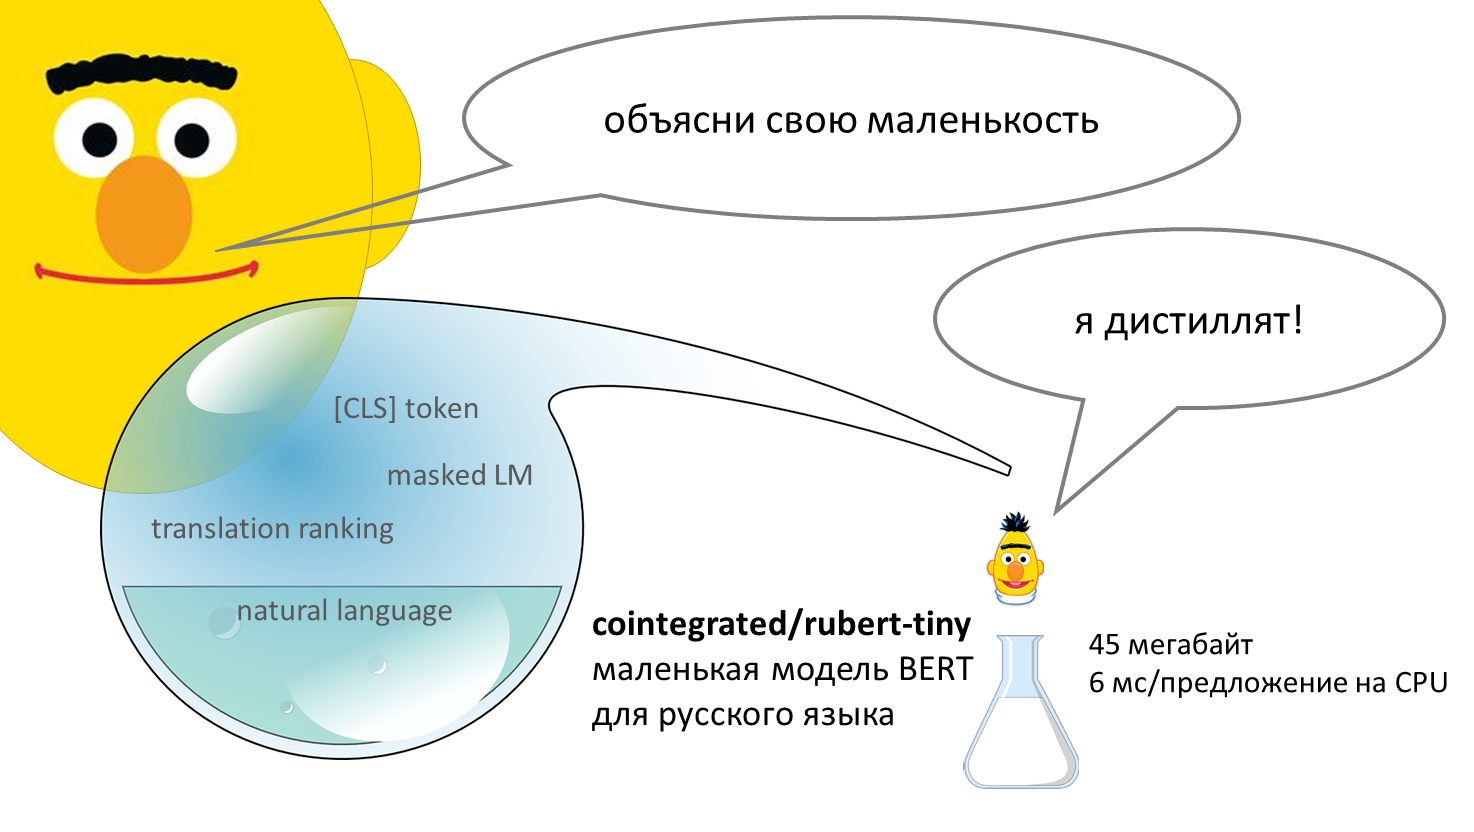

## Дооучение ruBERT-tiny2 для распознавания эмоций

Будем осуществлять дообучение модели ruBERT-tiny2 для распознавания эмоций на корпусе CEDR.

Загрузим необходимые библиотеки.

In [ ]:
!pip install transformers sentencepiece datasets -q

### Загрузка токенизатора и модели

Будем хранить модель на видеокарте, если она доступна. Это позволит ускорить вычисления.

- Если `torch.cuda.is_available() = True`, мы будем использовать CUDA (Compute Unified Device Architecture) для вычислений.

- Если `torch.cuda.is_available() = False`, вычисления будут производиться на CPU (central processing unit).

Чтобы выполнять вычисления на видеокарте, нужно зайти в раздел "Среда выполнения" -> "Сменить среду выполнения", выбрать аппаратный ускоритель T4 GPU
 (графический процессор).

In [ ]:
import torch
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(DEVICE)

Скачаем токенизатор и модель [ruBERT-tiny2](https://huggingface.co/cointegrated/rubert-tiny2) с помощью библиотеки Transformers. Для этого указываем идентификатор модели и используем метод `from_pretrained`.

Загрузка токенизатора осуществляется с помощью автоматического класса [AutoTokenizer](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer). Для загрузки модели используется класс [AutoModelForSequenceClassification](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForSequenceClassification): он уже содержит линейный слой поверх предобученной модели, который нужен для дообучения. Необходимо указать количество классов (`num_labels`) и тип задачи (`problem_type`):  каждому объекту присваивается одна метка (`single_label_classification`)  или несколько (`multi_label_classification`).

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

base_model = 'cointegrated/rubert-tiny2'
tokenizer = AutoTokenizer.from_pretrained(base_model)
model = AutoModelForSequenceClassification.from_pretrained(base_model, num_labels=6, problem_type='multi_label_classification').to(DEVICE)

In [ ]:
model

### Загрузка данных

Загрузим уже известный нам корпус [CEDR](https://huggingface.co/datasets/cedr) (основная версия).

In [ ]:
from datasets import load_dataset

cedr = load_dataset('cedr')

In [ ]:
cedr

При работе с моделью BERT предобработка осуществляется с помощью токенизатора. Он позволяет преобразовать токены в индексы в соответствии со словарем модели.

📌 Запишите в переменную `sent` текст какого-либо предложения набора данных. Примените токенизатор к этому предложению и запишите результат в переменную `tokenized_sent`. Какое преобразование осуществляется с предложением?

In [ ]:
# Место для вашего кода

Посмотрим, какие индексы в словаре соответствуют словам, с помощью метода  `convert_ids_to_tokens`.

In [ ]:
tokenizer.convert_ids_to_tokens(tokenized_sent["input_ids"])

### Преобразование меток класса

В описании датасета указано следующее соотношение эмоций и числовых меток:

`{0: "joy", 1: "sadness", 2: "surprise", 3: "fear", 4: "anger"}`

Однако нейтральному классу соответствует пустой список. Кроме того, у одного предложения может быть сразу несколько меток.

In [ ]:
cedr["train"][130]

In [ ]:
cedr["train"][131]

Будем считать, что изначальные метки сдвинуты на единицу, поскольку добавлен нейтральный класс (0 – без эмоций, 1 – радость, 2 – печаль, 3 – удивление, 4 – страх, 5 – злость). Определим заданное соответствие названий классов и меток в параметре `config`.



In [ ]:
LABELS = ['no_emotion', 'joy', 'sadness', 'surprise', 'fear', 'anger']
model.config.label2id = {label: i for i, label in enumerate(LABELS)}
print(model.config.label2id)
model.config.id2label = {i: label for i, label in enumerate(LABELS)}
print(model.config.id2label)

Для обучения модели необходимо перевести метки из списка в векторы.

📌 Напишем функцию `binarize_labels`:
- на вход поступает список с числовыми метками класса
- создается два новых списка
  - первый имеет длину 1:
     - содержит единицу, если изначальная метка объекта является пустым списком,
     - содержит ноль в противном случае;
  - второй имеет длину 5 и содержит единицу на тех позициях, которые указаны в списке меток
- два получившихся списка конкатенируются (складываются)

In [ ]:
# Место для вашего кода

Для проверки функции можно подать на вход несколько разных списков: пустой или с числами от 0 до 4.

In [ ]:
print(binarize_labels([]))
print(binarize_labels([0]))
print(binarize_labels([1, 4]))

### Обработка данных

С помощью метода `map` можно применить описанные выше преобразования ко всем объектам датасета:
- применить токенизатор к текстам, включая усечение до максимальной длины входных данных модели (`truncation=True`)
- преобразовать числовые метки классов в векторы из нулей и единиц, удалив лишние столбцы (`remove_columns=['text', 'labels', 'source']`)

In [ ]:
cedr_mapped = cedr.map(lambda x: tokenizer(x['text'], truncation=True), batched=True).map(lambda x: {'label': [float(y) for y in binarize_labels(x['labels'])]}, batched=False, remove_columns=['text', 'labels', 'source'])

In [ ]:
cedr_mapped

Отделим от обучающей выборки 300 объектов, которые будут использоваться для валидации.

In [ ]:
splitted = cedr_mapped['train'].train_test_split(test_size=300, seed=42)
splitted

При обучении нейронных сетей данные делят на части – батчи, и пропускают их через сеть по очереди. Внутри одного батча предложения должны иметь одинаковую длину. Этого можно добиться с помощью паддинга – более короткие предложения принудительно "удлиняются" за счет добавления нулей в список индексов. Для разбиения на батчи и паддинга используется класс [DataCollatorWithPadding](DataCollatorWithPadding).

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer)

Объект класса [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) — итератор, который позволяет создавать новые батчи.

Создадим `train_dataloader` — экземпляр класса `DataLoader`. Он принимает на вход  обучающую выборку `splitted['train']`, размер батча `batch_size`, значение параметра `shuffle` (при `True` данные перемешиваются каждую эпоху), функцию для разбиения на батчи `collate_fn`.

In [ ]:
from torch.utils.data import DataLoader

batch_size = 64

train_dataloader = DataLoader(
    splitted['train'],
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_collator
)

📌 По аналогии создайте `dev_dataloader` для валидационной выборки.

In [ ]:
# Место для вашего кода

Посмотрим, как выглядит первая выдача `train_dataloader` в цикле.

In [ ]:
data = next(iter(train_dataloader))
print(f'Батч:\n{data.keys()}\n')
print(f"Индексы токенов:\n{data['input_ids'].shape}\nbatch size x max len\n")
print(f"Индексы токенов:\n{data['token_type_ids'].shape}\nbatch size x max len\n")
print(f"Маски внимания:\n{data['attention_mask'].shape}\nbatch size x max len\n")
print(f"Метки классов:\n{data['labels'].shape}\nbatch size x num classes\n")

### Обучение

Функция `predict_with_model` используется для записи предсказанных моделью ответов, возвращает истинные метки `facts` и предсказания `preds`. Библиотека `tqdm` используется для создания индикаторов прогресса (progressbar) и отображения количества итераций и затраченного времени.

In [ ]:
import numpy as np
from tqdm.auto import tqdm

def predict_with_model(model, dataloader):
    preds = []
    facts = []

    for batch in tqdm(dataloader): # проход по батчам в цикле
        facts.append(batch.labels.cpu().numpy()) # атрибут labels содержит правильные ответы
        batch = batch.to(model.device) # модель и данные должны храниться в одном месте: CPU или CUDA
        # модель применяется к батчу
        with torch.no_grad():
            pr = model(input_ids=batch.input_ids, attention_mask=batch.attention_mask, token_type_ids=batch.token_type_ids)
        # к предсказаниям применяется функция активации softmax
        preds.append(torch.softmax(pr.logits, -1).cpu().numpy())

    facts = np.concatenate(facts)
    preds = np.concatenate(preds)
    return facts, preds

Для оценки качества модели на валидационной выборке используется [AUC-ROC ](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)— площадь (Area Under Curve) под кривой ошибок (Receiver Operating Characteristic curve). Данная кривая представляет из себя линию от (0,0) до (1,1) в координатах:

- True Positive Rate (TPR) — полнота (recall) или чувствительность (sensitivity). Показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм.

$$TPR = \frac{TP}{TP + FN}$$
- False Positive Rate (FPR) — специфичность (specificity). Показывает, какую долю из объектов отрицательного класса алгоритм предсказал неверно.
$$FPR = \frac{FP}{FP + TN}$$

Необходимо вычислить метрики и построить их на одном графике с осями FPR и TPR. Результирующая кривая представляет собой кривую ROC, а площадь под кривой является метрикой AUC-ROC.

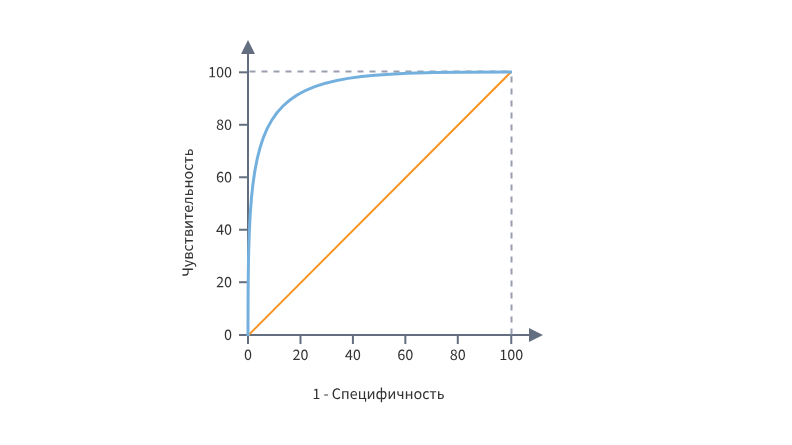

В идеальном случае, когда классификатор не делает ошибок (FPR = 0, TPR = 1), площадь под кривой равна единице. Когда классификатор случайно выдает вероятности классов, AUC-ROC будет стремиться к 0.5, так как классификатор будет выдавать одинаковое количество TP и FP.

В случае многометочной классификации создается $K$ бинарных классификаторов ($K$ — количество классов), поэтому AUC-ROC для каждого рассчитывается отдельно.

📌 Допишите, как с помощью предыдущей функции получить истинные и предсказанные ответы.

In [ ]:
from sklearn.metrics import roc_auc_score

def evaluate_model(model, dev_dataloader):
    facts, preds = # Место для вашего кода
    # подсчитываем AUC-ROC для каждого класса
    aucs = [roc_auc_score(facts[:, i], preds[:, i]) for i in range(6)]
    return aucs, np.mean(aucs)

Перед началом обучения модели необходимо определить некоторые дополнительные параметры.

In [ ]:
# алгоритм оптимизации функции потерь и скорость обучения
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-5)
# значение шага для вывода результатов
report_step = 10000

Процесс обучения выполняется циклом длиной в количество эпох — полных проходов через обучающий набор данных:


*  Прямое распространение: модель применяется к данным с текущими весами.
*  Путем сравнения предсказанного значения с истинным ответом вычисляется значение функции потерь.
*  Ищем градиент – направление максимального роста функции потерь при текущих весах.
*  Обратное распространение: обновляем веса, перемещаясь по функции потерь в обратном градиенту направлении.


In [ ]:
from tqdm.auto import trange

model.train()

for epoch in trange(30):
    tq = tqdm(train_dataloader)

    # проход по батчам в цикле
    for i, batch in enumerate(tq):

        # модель и данные должны храниться в одном месте: CPU или CUDA
        batch = batch.to(model.device)
        # модель применяется к батчу
        output = model(**batch)
        # считаем значение функции потерь
        loss = output.loss
        # считаем градиенты по всем параметрам модели
        loss.backward()

        # после прохода по каждому батчу кроме нулевого происходит обновление весов с помощью шага оптимизатора
        if i != 0:
            # обновление весов
            optimizer.step()
            # обнуление градиентов
            optimizer.zero_grad()

        # после каждого 10000-го батча выводятся значения метрик
        if i % report_step == 0:
            model.eval()
            aucs, eval_loss = evaluate_model(model, dev_dataloader)
            model.train()
            print(f'epoch {epoch}, step {i}: train loss: {loss.item():4.4f}  val auc: {eval_loss}')
            print('aucs', aucs)

### Тестирование

Преобразуем тестовый набор данных в объект класса DataLoader. Запишем предсказания обученной модели на тестовых данных.

In [ ]:
test_dataloader = DataLoader(
    cedr_mapped['test'],
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_collator
)

In [ ]:
model.eval()
facts, preds = predict_with_model(model, test_dataloader)

Метрики качества на корпусе CEDR определяются двумя способами:
- микро- и макроусредненная F-мера для каждой эмоции
- точность, полнота и F-мера для каждого класса

In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
# Микро- и макроусредненные значения F-меры для каждого бинарного классификатора

binary_report = pd.DataFrame([
    {av: f1_score(facts[:, i], preds[:, i] > 0.5, average=av) for av in ['micro', 'macro']}
    for i in range(6)
]).round(2)
binary_report.loc[len(binary_report), ['micro','macro']] = binary_report['micro'].mean(), binary_report['macro'].mean()
binary_report = binary_report.rename(index={0: 'no emotion', 1: 'joy', 2: 'sadness', 3: 'surprise', 4: 'fear', 5: 'anger', 6: 'mean'})
binary_report.style.format(precision=2)

In [ ]:
# Значения точности, полноты и F-меры для каждого класса

class_report = pd.DataFrame([
    {precision_score(facts[:, i], preds[:, i] > 0.5),
     recall_score(facts[:, i], preds[:, i] > 0.5),
     f1_score(facts[:, i], preds[:, i] > 0.5)}
    for i in range(6)
    ], ).round(2)
mean_report = pd.DataFrame([
    {precision_score(facts[:,:6], preds[:,:6] > 0.5, average=av), recall_score(facts[:,:6], preds[:,:6] > 0.5, average=av), f1_score(facts[:,:6], preds[:,:6] > 0.5, average=av)}
    for av in ['micro', 'macro', 'weighted', 'samples']
]).round(2)
report = pd.concat([class_report, mean_report], ignore_index=True)
report = report.rename(columns={0: "precision", 1: "recall", 2: "f1_score"})
report = report.rename(index={0: 'no emotion', 1: 'joy', 2: 'sadness', 3: 'surprise', 4: 'fear', 5: 'anger', 6: 'micro', 7: 'macro', 8: 'weighted', 9: 'samples'})
report

### Загрузка и тестирование модели из Hugging Face

📌 Скачайте [модель ruBERT-tiny, обученную для распознавания эмоций на корпусе CEDR](https://huggingface.co/cointegrated/rubert-tiny2-cedr-emotion-detection).

In [ ]:
cedr_tokenizer = # Место для вашего кода
cedr_model = # Место для вашего кода

📌 Запишите предсказания модели на тестовом наборе данных.

In [ ]:
model.eval()
cedr_facts, cedr_preds = # Место для вашего кода

In [ ]:
# Микро- и макроусредненные значения F-меры для каждого бинарного классификатора

binary_report = pd.DataFrame([
    {av: f1_score(cedr_facts[:, i], cedr_preds[:, i] > 0.5, average=av) for av in ['micro', 'macro']}
    for i in range(6)
]).round(2)
binary_report.loc[len(binary_report), ['micro','macro']] = binary_report['micro'].mean(), binary_report['macro'].mean()
binary_report = binary_report.rename(index={0: 'no emotion', 1: 'joy', 2: 'sadness', 3: 'surprise', 4: 'fear', 5: 'anger', 6: 'mean'})
binary_report.style.format(precision=2)

In [ ]:
# Значения точности, полноты и F-меры для каждого класса

class_report = pd.DataFrame([
    {precision_score(cedr_facts[:, i], cedr_preds[:, i] > 0.5),
     recall_score(cedr_facts[:, i], cedr_preds[:, i] > 0.5),
     f1_score(cedr_facts[:, i], cedr_preds[:, i] > 0.5)}
    for i in range(6)
    ], ).round(2)
mean_report = pd.DataFrame([
    {precision_score(cedr_facts[:,:6], cedr_preds[:,:6] > 0.5, average=av),
     recall_score(cedr_facts[:,:6], cedr_preds[:,:6] > 0.5, average=av),
     f1_score(cedr_facts[:,:6], cedr_preds[:,:6] > 0.5, average=av)}
    for av in ['micro', 'macro', 'weighted', 'samples']
]).round(2)
report = pd.concat([class_report, mean_report], ignore_index=True)
report = report.rename(columns={0: "precision", 1: "recall", 2: "f1_score"})
report = report.rename(index={0: 'no emotion', 1: 'joy', 2: 'sadness', 3: 'surprise', 4: 'fear', 5: 'anger', 6: 'micro', 7: 'macro', 8: 'weighted', 9: 'samples'})
report